## MICROSOFT RECOMMENDER, SAR ALGORITHM  

# Load Packages

In [133]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scrapbook as sb
import matplotlib.pyplot as plt
import scipy, logging, sys, warnings, joblib
from sklearn.preprocessing import minmax_scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import recommenders
from recommenders.models.sar import SAR 
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import (precision_at_k, mae, rsquared)

%load_ext autoreload
%autoreload 2
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
warnings.filterwarnings('ignore')
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.4.4


# Define a list of top_k items that will be recommended to users

In [134]:
list_top_k=[3,5,10]#

# Load the data
	MovieLens 1M dataset

In [135]:
data=pd.read_csv('ML_1M.csv')
data.head()

,userID,itemID,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [136]:
# check the shape of dataset
data.shape

(1000209, 4)

In [137]:
# convert the ratings to float32 to reduce memory usage
data['rating'] = data['rating'].astype(np.float32)
data.head()

,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


# Split the data into train and test sets
	75% train set and 25% test set

In [138]:
train, test = python_stratified_split(data, 
                                      ratio=0.75,
                                      col_user='userID',
                                      col_item='itemID',
                                      seed=0)
#(train.shape, test.shape)

In [139]:
print(
f"""Train: 
Total Ratings: {len(train)}
Unique Users:  {len(train['userID'].unique())}
Unique Items:  {len(train['itemID'].unique())}
"""
     )

print(
f"""Test: 
Total Ratings: {len(test)}
Unique Users:  {len(test['userID'].unique())}
Unique Items:  {len(test['itemID'].unique())}
"""
     )

Train: 
Total Ratings: 750121
Unique Users:  6040
Unique Items:  3675

Test: 
Total Ratings: 250088
Unique Users:  6040
Unique Items:  3500



# Define the list of the similarities that will be investigated
Similarity type must be one of available similarity metrics:
	
	"cooccurrence", "jaccard", "lift", "HD_JACCARD", "DICE", "JACCARD_3W", "SOKAL_SNEATH_I", "COSINE", "SORGENFREI", "MOUNTFORD", "MCCONNAUGHEY", "KULCZYNSKI_II", "DRIVER_KROEBER", "JOHNSON", "SIMPSON", "BRAUN_BANQUET", "FAGER_MCGOWAN", "EUCLID", "MINKOWSKI", "LANCE_WILLIAMS", "HELLINGER", "CHORD",
 
	"SOKAL_MICHENER", "SOKAL_SNEATH_II", "SOKAL_SNEATH_IV", "SOKAL_SNEATH_V",  "PEARSON_I", "PEARSON_II", "PEARSON_III", "PEARSON_HERON_I", "PEARSON_HERON_II", "BARONI_URBANI_BUSER_I", "BARONI_URBANI_BUSER_II", "FORBES_I", "FORBES_II", "YULEQ", "YULEQ_W", "TARANTULA", "AMPLE", "ROGERS_TANIMOTO", "FAITH", "GOWER_LEGENDRE", "INNERPRODUCT", "RUSSELL_RAO", "TARWID", "DENNIS", "GOWER", "STILES", "FOSSUM", "DISPERSON", "HAMANN", "MICHAEL", "PEIRCE", "EYRAUD", "YULEQ_D", "MEAN_MANHATTAN", "VARI", "SHAPEDIFFERENCE", "PATTERNDIFFERENCE

In [140]:
# The list of the similarity metrics that already implemented in SAR algorithm
list_already_exist=[
    "jaccard" , 
    "lift"
    ]
print(len(list_already_exist),'similarity metrics already implemented')

2 similarity metrics already implemented


In [141]:
#Define the list of the similarity metrics without negative co-occurrences
list_metrics=[
    # similarities
    "DICE", "JACCARD_3W", "SOKAL_SNEATH_I", "COSINE", "SORGENFREI", "MOUNTFORD",
    "MCCONNAUGHEY", "KULCZYNSKI_II", "DRIVER_KROEBER", "JOHNSON", "SIMPSON", 
    "BRAUN_BANQUET", "FAGER_MCGOWAN",
    # distances
    "EUCLID", "MINKOWSKI", "LANCE_WILLIAMS", "HELLINGER", "CHORD"
    ]
print(len(list_metrics),'similarity metrics')

18 similarity metrics


In [142]:
#Define the list of the similarity metrics with negative co-occurrences
list_metrics_d=[
# similarities with negative co-occurrences 
"SOKAL_MICHENER", "SOKAL_SNEATH_II", "SOKAL_SNEATH_IV",  "PEARSON_I", 
"PEARSON_II", "PEARSON_III", "PEARSON_HERON_I", "PEARSON_HERON_II", "BARONI_URBANI_BUSER_I", 
"BARONI_URBANI_BUSER_II",  "FORBES_I",  "FORBES_II", "YULEQ", "YULEQ_W", "TARANTULA",  "AMPLE",
"ROGERS_TANIMOTO", "FAITH",  "GOWER_LEGENDRE", "INNERPRODUCT", "RUSSELL_RAO", "TARWID",
"DENNIS", "GOWER",  "STILES", "FOSSUM", "DISPERSON",  "HAMANN",  "MICHAEL", "PEIRCE", "EYRAUD",

# distances with negative co-occurrences 
"YULEQ_D", "MEAN_MANHATTAN", "VARI", "SHAPEDIFFERENCE", "PATTERNDIFFERENCE" ]

print(len(list_metrics_d),'similarity metrics')

36 similarity metrics


In [143]:
# combine all similarities to train them in the sar algorithm 
list_all_metrics=list_already_exist+list_metrics+list_metrics_d
print('Total N° of SM: ',len(list_all_metrics))

Total N° of SM:  56


# Initialization  of models

In [144]:
list_models=[]
for metric in list_all_metrics:
    model                  = SAR(
    col_user               = "userID",
    col_item               = "itemID",
    col_rating             = "rating",
    similarity_type        =  metric, 
        
    normalize              =  True, 
    time_decay_coefficient =  30, 
    timedecay_formula      =  True,
    col_timestamp          = "timestamp"
    )
    list_models.append(model)
print('Initiated models : ',len(list_models))

Initiated models :  56


# Train models

In [146]:
with Timer() as train_time:
    i=0
    for model in list_models:
        model.fit(train)
        print(f"model_{i+1}_{list_all_metrics[i]} trained.")
        ## save the model to disk to make checkpoints 
        #filename = f'model_{i+1}_{list_all_metrics[i]}.sav'
        #joblib.dump(model, filename)  
        #print(f"model_{i+1} {list_all_metrics[i]} saved.")
        i+=1

print(f"Took {train_time.interval} seconds for training.")

model_1_jaccard trained.
model_2_lift trained.
model_3_DICE trained.
model_4_JACCARD_3W trained.
model_5_SOKAL_SNEATH_I trained.
model_6_COSINE trained.
model_7_SORGENFREI trained.
model_8_MOUNTFORD trained.
model_9_MCCONNAUGHEY trained.
model_10_KULCZYNSKI_II trained.
model_11_DRIVER_KROEBER trained.
model_12_JOHNSON trained.
model_13_SIMPSON trained.
model_14_BRAUN_BANQUET trained.
model_15_FAGER_MCGOWAN trained.
model_16_EUCLID trained.
model_17_MINKOWSKI trained.
model_18_LANCE_WILLIAMS trained.
model_19_HELLINGER trained.
model_20_CHORD trained.
model_21_SOKAL_MICHENER trained.
model_22_SOKAL_SNEATH_II trained.
model_23_SOKAL_SNEATH_IV trained.
model_24_PEARSON_I trained.
model_25_PEARSON_II trained.
model_26_PEARSON_III trained.
model_27_PEARSON_HERON_I trained.
model_28_PEARSON_HERON_II trained.
model_29_BARONI_URBANI_BUSER_I trained.
model_30_BARONI_URBANI_BUSER_II trained.
model_31_FORBES_I trained.
model_32_FORBES_II trained.
model_33_YULEQ trained.
model_34_YULEQ_W trained.


# Make recommendations (predictions) : top_k=3,5,10

In [147]:
list_of_list_k_items=[]
with Timer() as test_time:
    for i in list_top_k:
        print(f'Recommending Top_{i}')
        list_models_K_items=[]
        for model in list_models:
            list_models_K_items.append(model.recommend_k_items(test,i,remove_seen=True))
        list_of_list_k_items.append(list_models_K_items)
        print(f'Top_k_{i} is done')
        del list_models_K_items
print(f"Took {test_time.interval} seconds for prediction.")

Recommending Top_3
Top_k_3 is done
Recommending Top_5
Top_k_5 is done
Recommending Top_10
Top_k_10 is done
Took 1604.156322200004 seconds for prediction.


# Evaluation
	compute the MAE, P@K, and R² for each Top_K

In [148]:
list_of_list_PRECISION, list_of_list_MAE, list_of_list_R_SQUARED=[], [], []
for i in range(len(list_top_k)):
    list_MAE_1,list_PRECISION_1,list_R_SQUARED_1=[], [], []
    j=1
    for top_k in list_of_list_k_items[i]:
        list_MAE_1.append(mae(test, top_k, col_user='userID', col_item='itemID', col_rating='rating'))
        list_R_SQUARED_1.append(rsquared(test, top_k, col_user='userID', col_item='itemID', col_rating='rating'))
        list_PRECISION_1.append(precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', 
                                               k=list_top_k[i]))
        #print(j)
        j+=1
    print(f'list for Top_k={list_top_k[i]} done')
    list_of_list_MAE.append(list_MAE_1)
    list_of_list_PRECISION.append(list_PRECISION_1)
    list_of_list_R_SQUARED.append(list_R_SQUARED_1)
    del list_MAE_1,list_PRECISION_1,list_R_SQUARED_1

positivity_threshold = 2
test_bin             = test.copy()
test_bin['rating']   = binarize(test_bin['rating'], positivity_threshold)

list for Top_k=3 done
list for Top_k=5 done
list for Top_k=10 done


# Save the results

In [159]:
# To make difference between the similarity metrics without negative cooccurrences 
# and similarity metrics without negative cooccurrences
#Define the list of the similarity metrics with negative co-occurrences
list_metrics_dd=[
# similarities with negative co-occurrences 
"D_SOKAL_MICHENER", "D_SOKAL_SNEATH_II", "D_SOKAL_SNEATH_IV",  "D_PEARSON_I", 
"D_PEARSON_II", "D_PEARSON_III", "D_PEARSON_HERON_I", "D_PEARSON_HERON_II", "D_BARONI_URBANI_BUSER_I", 
"D_BARONI_URBANI_BUSER_II",  "D_FORBES_I",  "D_FORBES_II", "D_YULEQ", "D_YULEQ_W", "D_TARANTULA",  
"D_AMPLE", "D_ROGERS_TANIMOTO", "D_FAITH",  "D_GOWER_LEGENDRE", "D_INNERPRODUCT", "D_RUSSELL_RAO",
"D_TARWID", "D_DENNIS", "D_GOWER",  "D_STILES", "D_FOSSUM", "D_DISPERSON",  "D_HAMANN", 
"D_MICHAEL", "D_PEIRCE", "D_EYRAUD",

# distances with negative co-occurrences 
"D_YULEQ_D", "D_MEAN_MANHATTAN", "D_VARI", "D_SHAPEDIFFERENCE", "D_PATTERNDIFFERENCE" ]

print(len(list_metrics_dd),'similarity metrics with d and a prefix D')

36 similarity metrics with d and a prefix D


In [160]:
list_dic=[]
for i in range(len(list_top_k)):
    dic={
        "Top K": list_top_k[i],
        "MAE": list_of_list_MAE[i],
        "Precision@K": list_of_list_PRECISION[i],
        "R2": list_of_list_R_SQUARED[i],
        }
    list_dic.append(dic)

In [205]:
list_dataframe=[]
for i in range(len(list_top_k)):
    dataframe=pd.DataFrame.from_dict(list_dic[i])
    dataframe.index=list_already_exist+list_metrics+list_metrics_dd
    list_dataframe.append(dataframe)
    dataframe.to_excel(f"Evaluation_Matrix_Top{list_top_k[i]}.xlsx")
    del dataframe

In [162]:
DATA=list_dataframe[0]
for i in range(1,len(list_top_k)):
    DATA=pd.concat([DATA, list_dataframe[i]], axis=0)
DATA.head(10)

,Top K,MAE,Precision@K,R2
jaccard,3,1.060020,0.333223,-0.833062
lift,3,1.459681,0.000221,-3.746657
DICE,3,0.925584,0.331678,-0.383787
JACCARD_3W,3,0.876307,0.330353,-0.227641
SOKAL_SNEATH_I,3,1.261990,0.333664,-1.597688
COSINE,3,1.113947,0.301711,-1.321637
SORGENFREI,3,1.031211,0.237583,-0.973250
MOUNTFORD,3,1.124322,0.290011,-1.337388
MCCONNAUGHEY,3,3.349310,0.000386,-77.789460
KULCZYNSKI_II,3,1.141433,0.245254,-1.258484


In [165]:
# save the tables a Excel format
DATA.to_excel("Evaluation Metrics Top_3_5_10.xlsx")

In [166]:
split=len(list_already_exist+list_metrics)
split

20

# Plot the MAE, P@K, and R² for the similarity metric without negative co-occurrences

In [167]:
 #list_dataframe[0][:split].sort_values("MAE",ascending=False).index

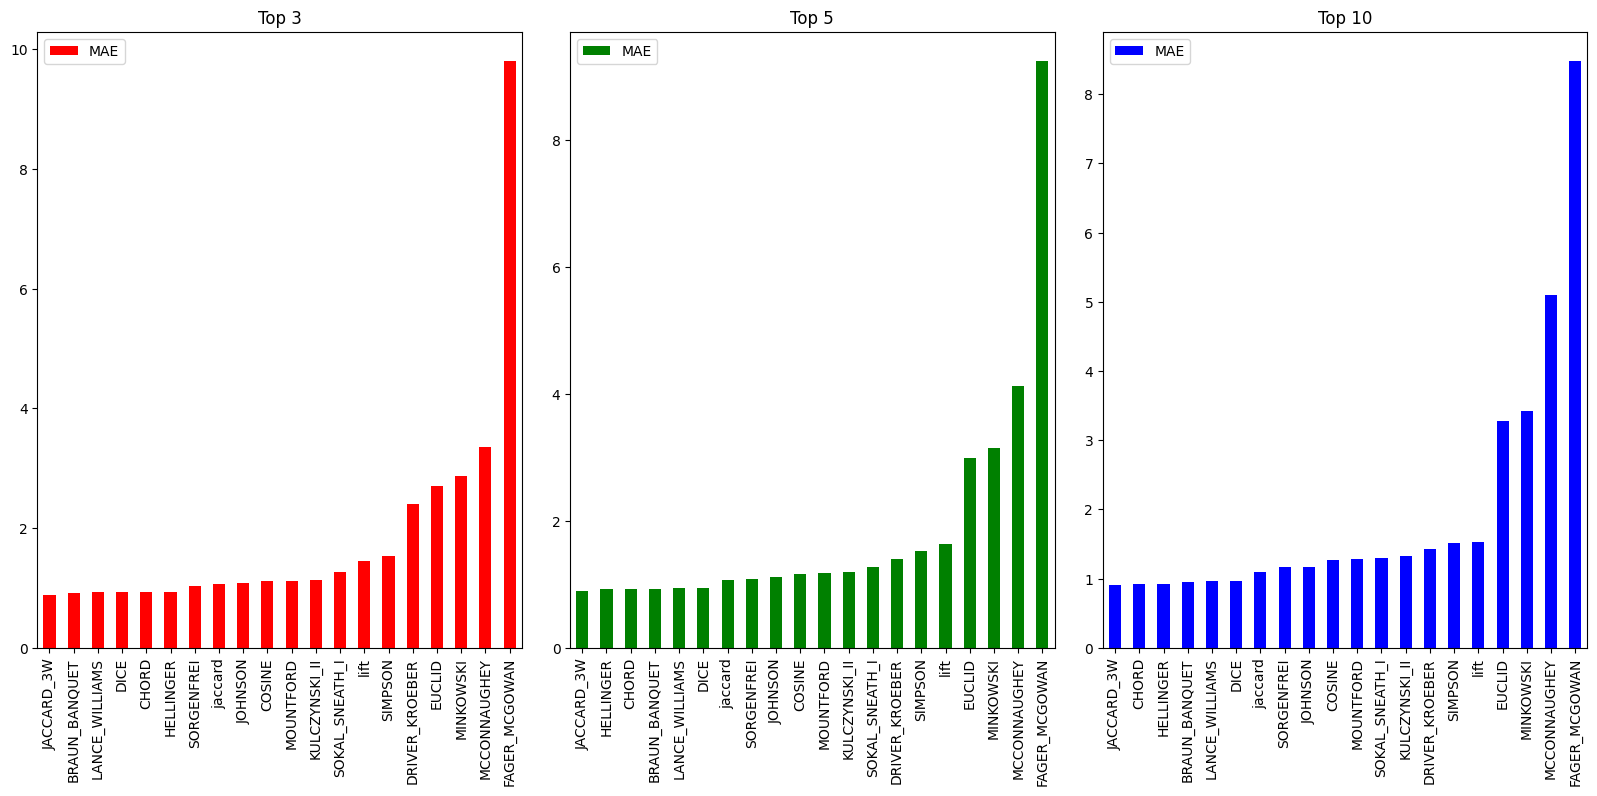

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][:split][['MAE']].sort_values(by='MAE',ascending=True)
    data['MAE'].plot(ax=axes[i], kind='bar', color=col[i], legend='MAE', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_MAE.jpg", bbox_inches='tight', dpi=1000)

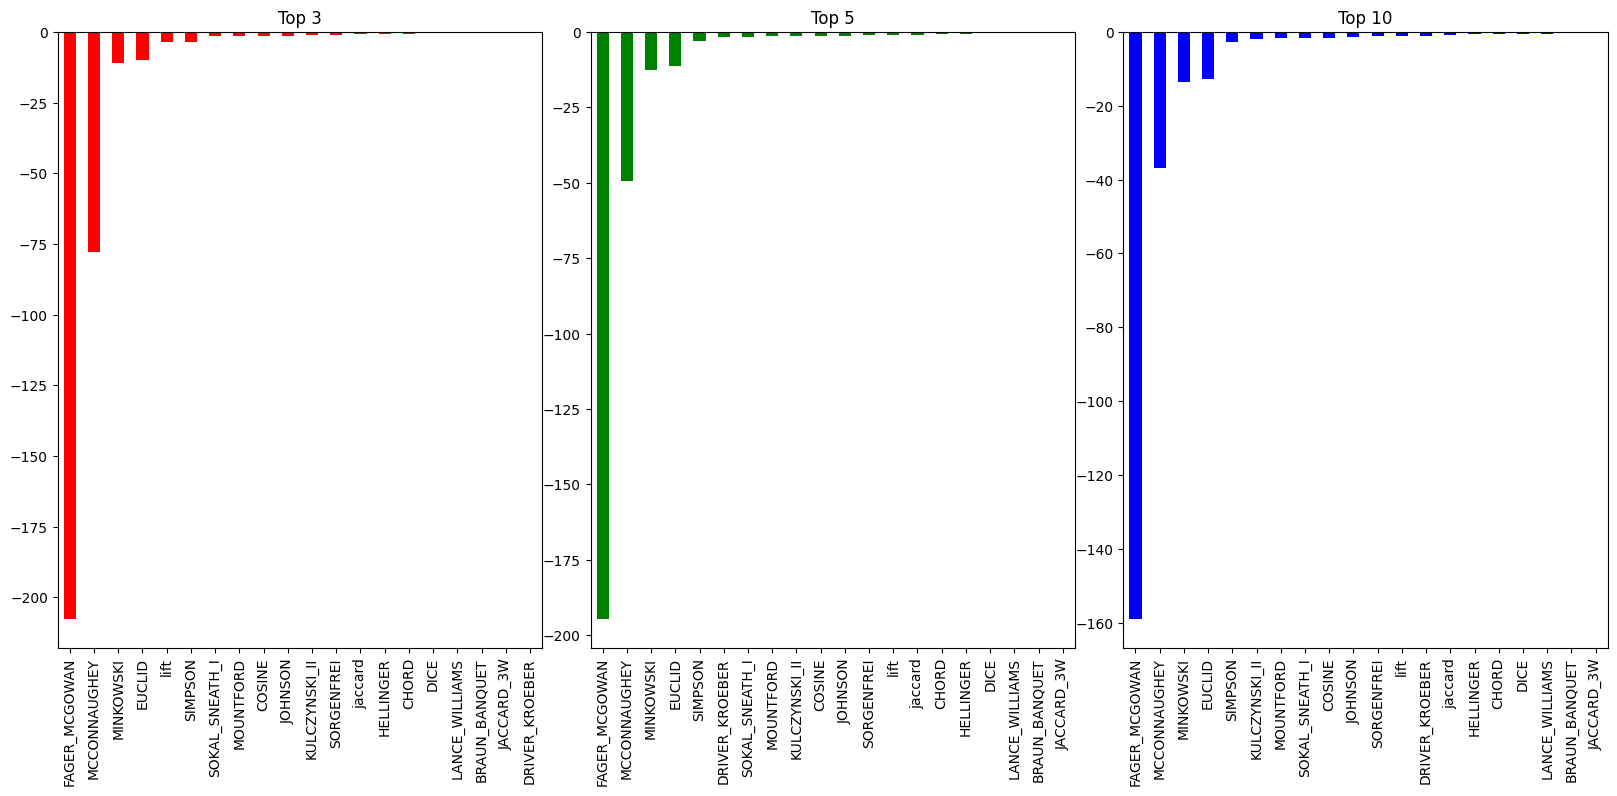

In [210]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][:split][['R2']].sort_values(by='R2',ascending=True)
    data['R2'].plot(ax=axes[i], kind='bar', color=col[i], y='R2', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_R2.jpg", bbox_inches='tight', dpi=1000)

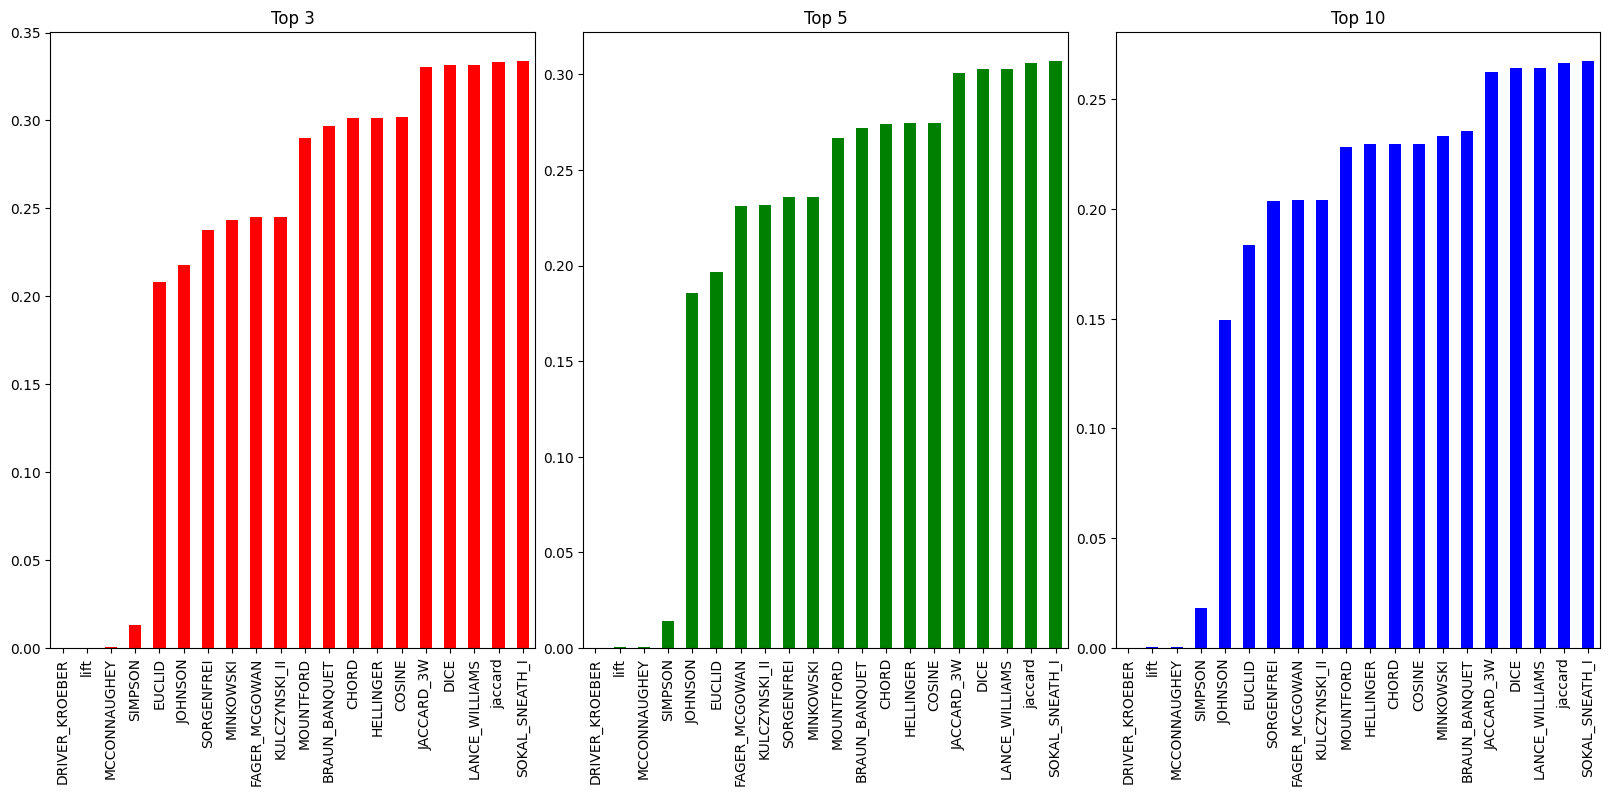

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][:split][['Precision@K']].sort_values(by='Precision@K',ascending=True)
    data['Precision@K'].plot(ax=axes[i], kind='bar', color=col[i], y='Precision@K', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_P@K.jpg", bbox_inches='tight', dpi=1000)

# Plot the MAE, P@K, and R² for the similarity metrics with negative co-occurrences

In [99]:
 #list_dataframe[0][split:].index

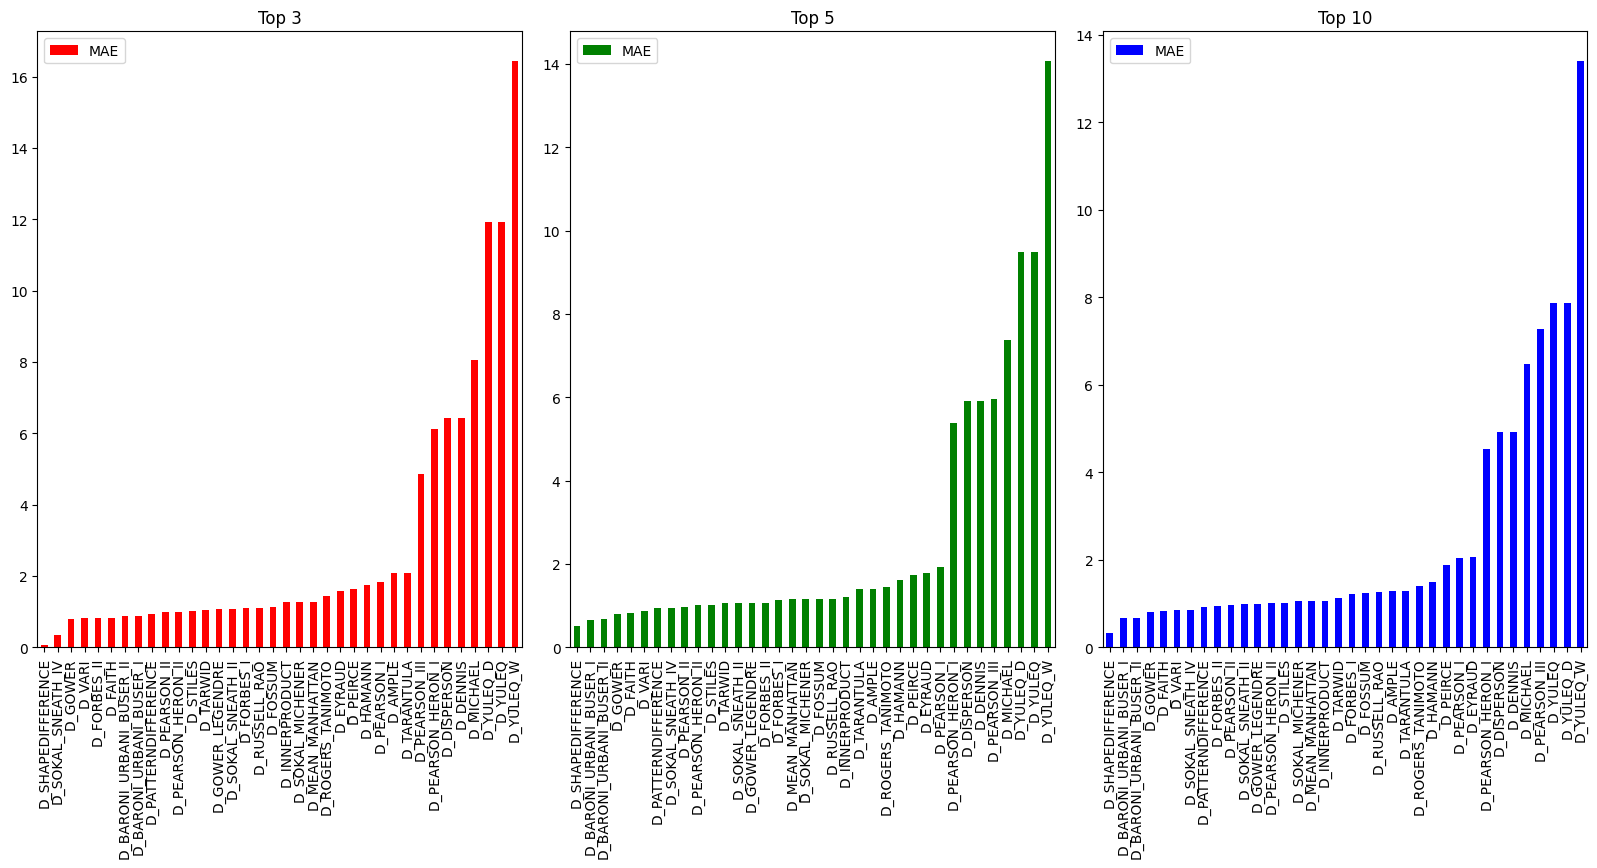

In [208]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][split:][['MAE']].sort_values(by='MAE',ascending=True)
    data['MAE'].plot(ax=axes[i], kind='bar', color=col[i], legend='MAE', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_D_MAE.jpg", bbox_inches='tight', dpi=1000)

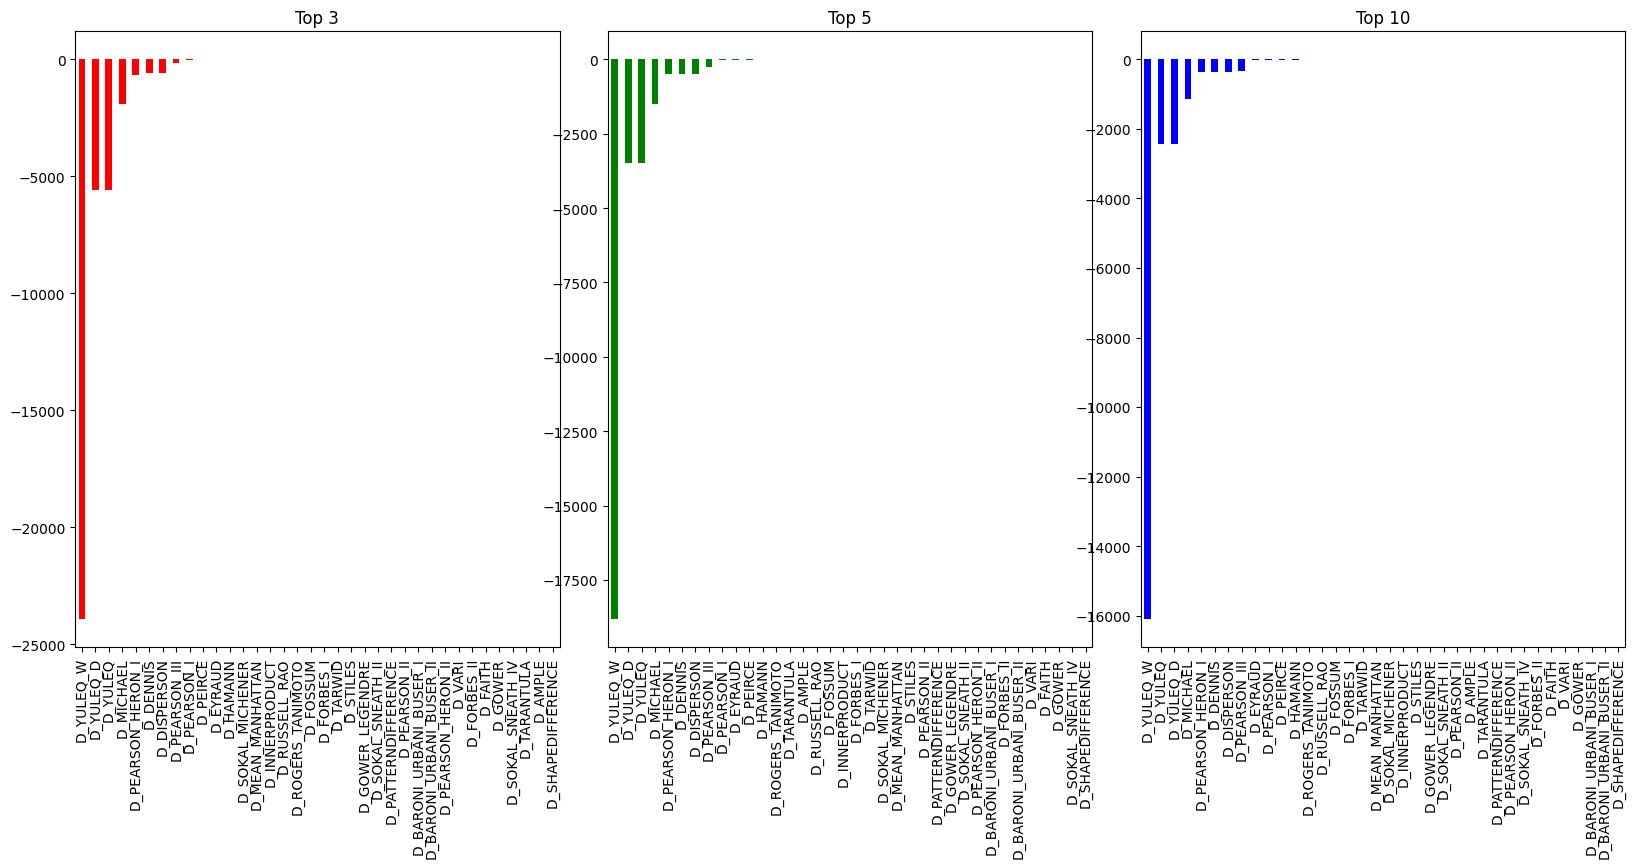

In [207]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][split:][['R2']].sort_values(by='R2',ascending=True)
    data['R2'].plot(ax=axes[i], kind='bar', color=col[i], y='R2', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_D_R2.jpg", bbox_inches='tight', dpi=1000)

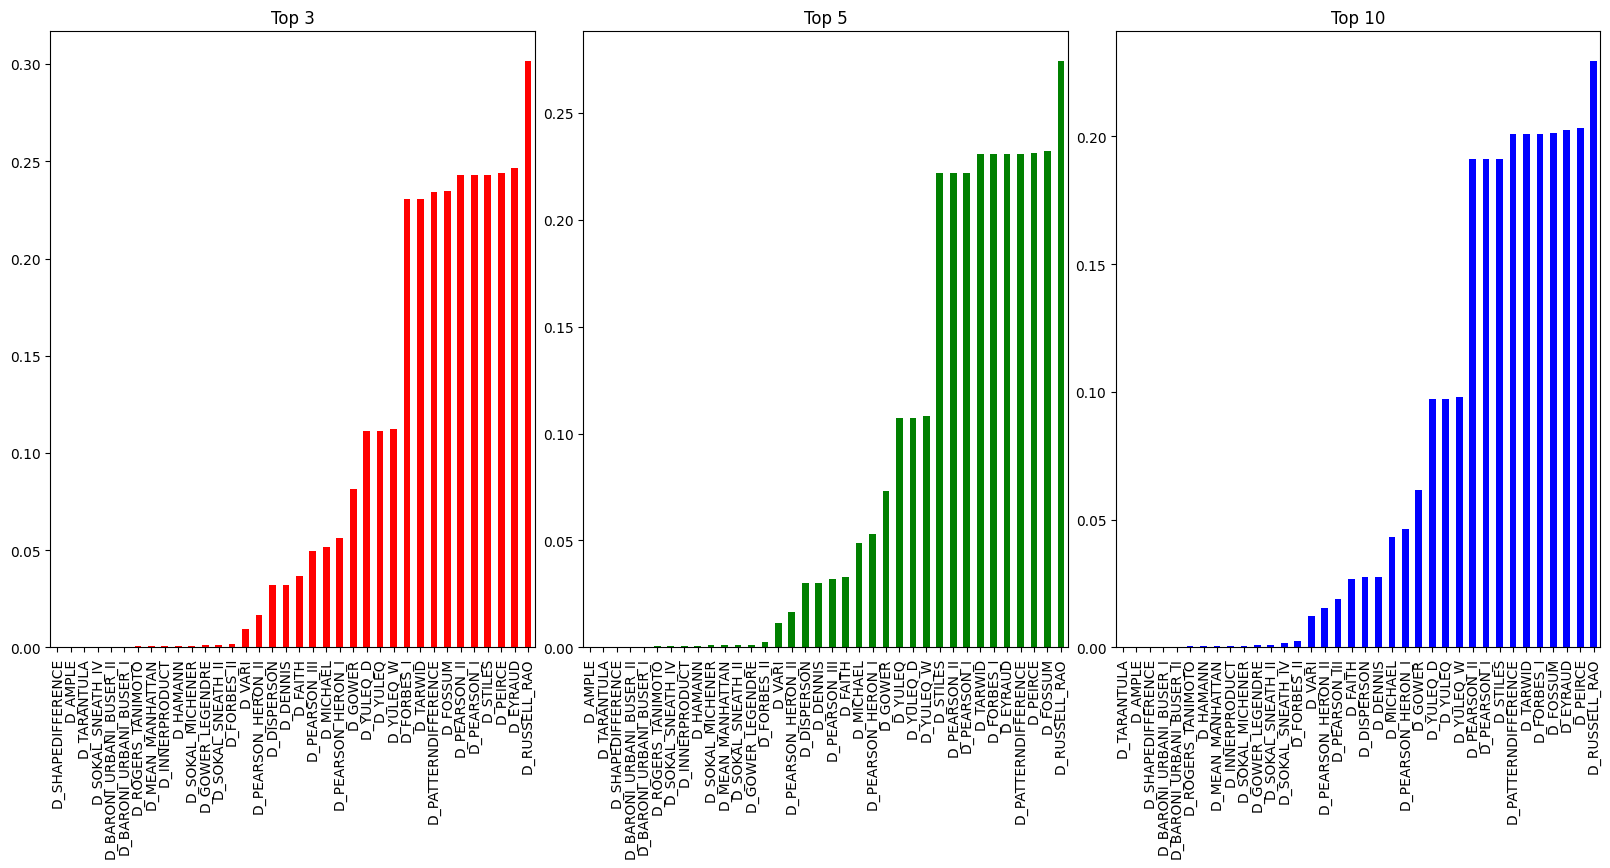

In [206]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][split:][['Precision@K']].sort_values(by='Precision@K',ascending=True)
    data['Precision@K'].plot(ax=axes[i], kind='bar', color=col[i], y='Precision@K', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_D_P@K.jpg", bbox_inches='tight', dpi=1000)

# Plot the clustering of the similarity metrics with CAH 

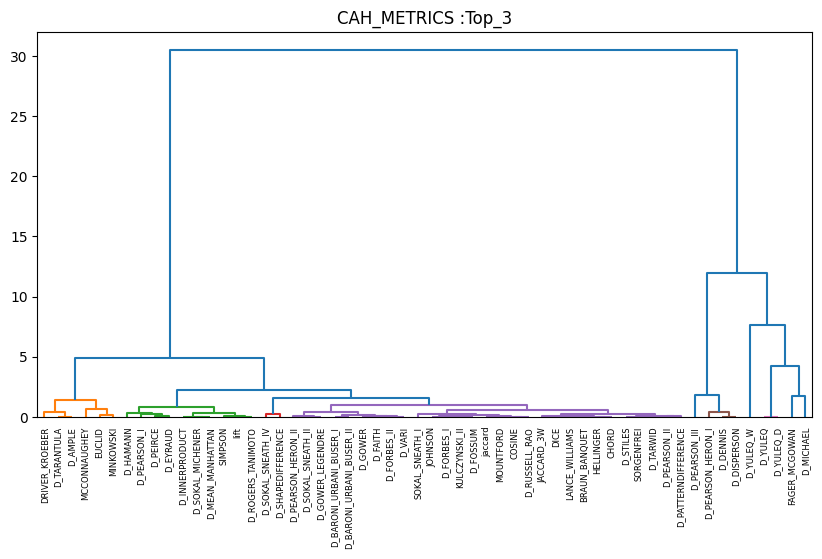

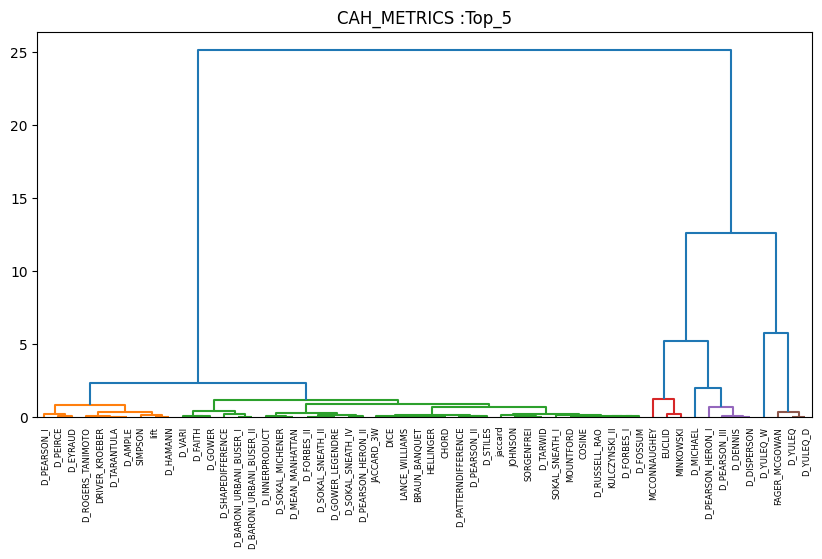

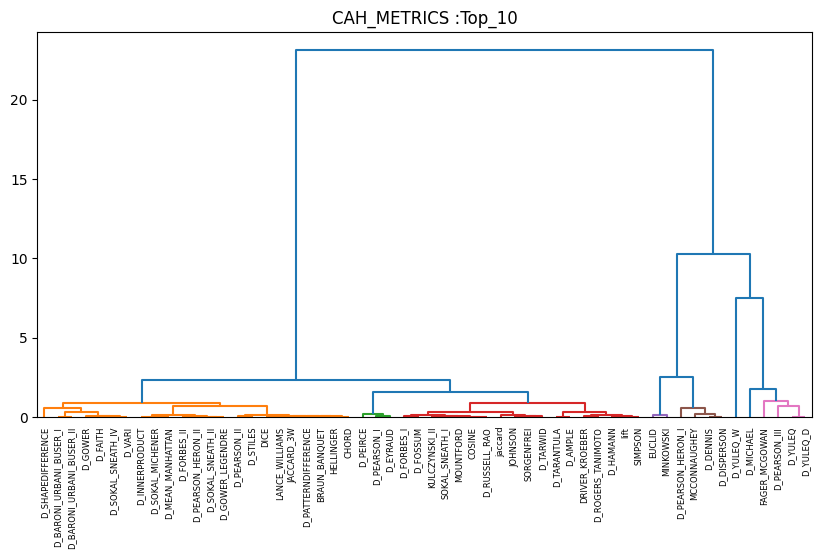

In [196]:
for i in range(len(list_top_k)):
    fig = plt.figure(figsize=(10,5))
    Z = linkage(list_dataframe[i].drop('R2',axis=1),method='ward',metric='euclidean') 
    # complete average ward single
    plt.title(f"CAH_METRICS :Top_{list_top_k[i]}")
    dendrogram(Z,labels=list_dataframe[i].index,orientation='top',color_threshold=1.5)
    plt.savefig(f'Top_{list_top_k[i]} clustring.png',dpi=1000)

In [104]:
# Save the cluster into local
#classter.to_excel("classterS.xlsx")

# Plot the correlation between the similarity metrics 

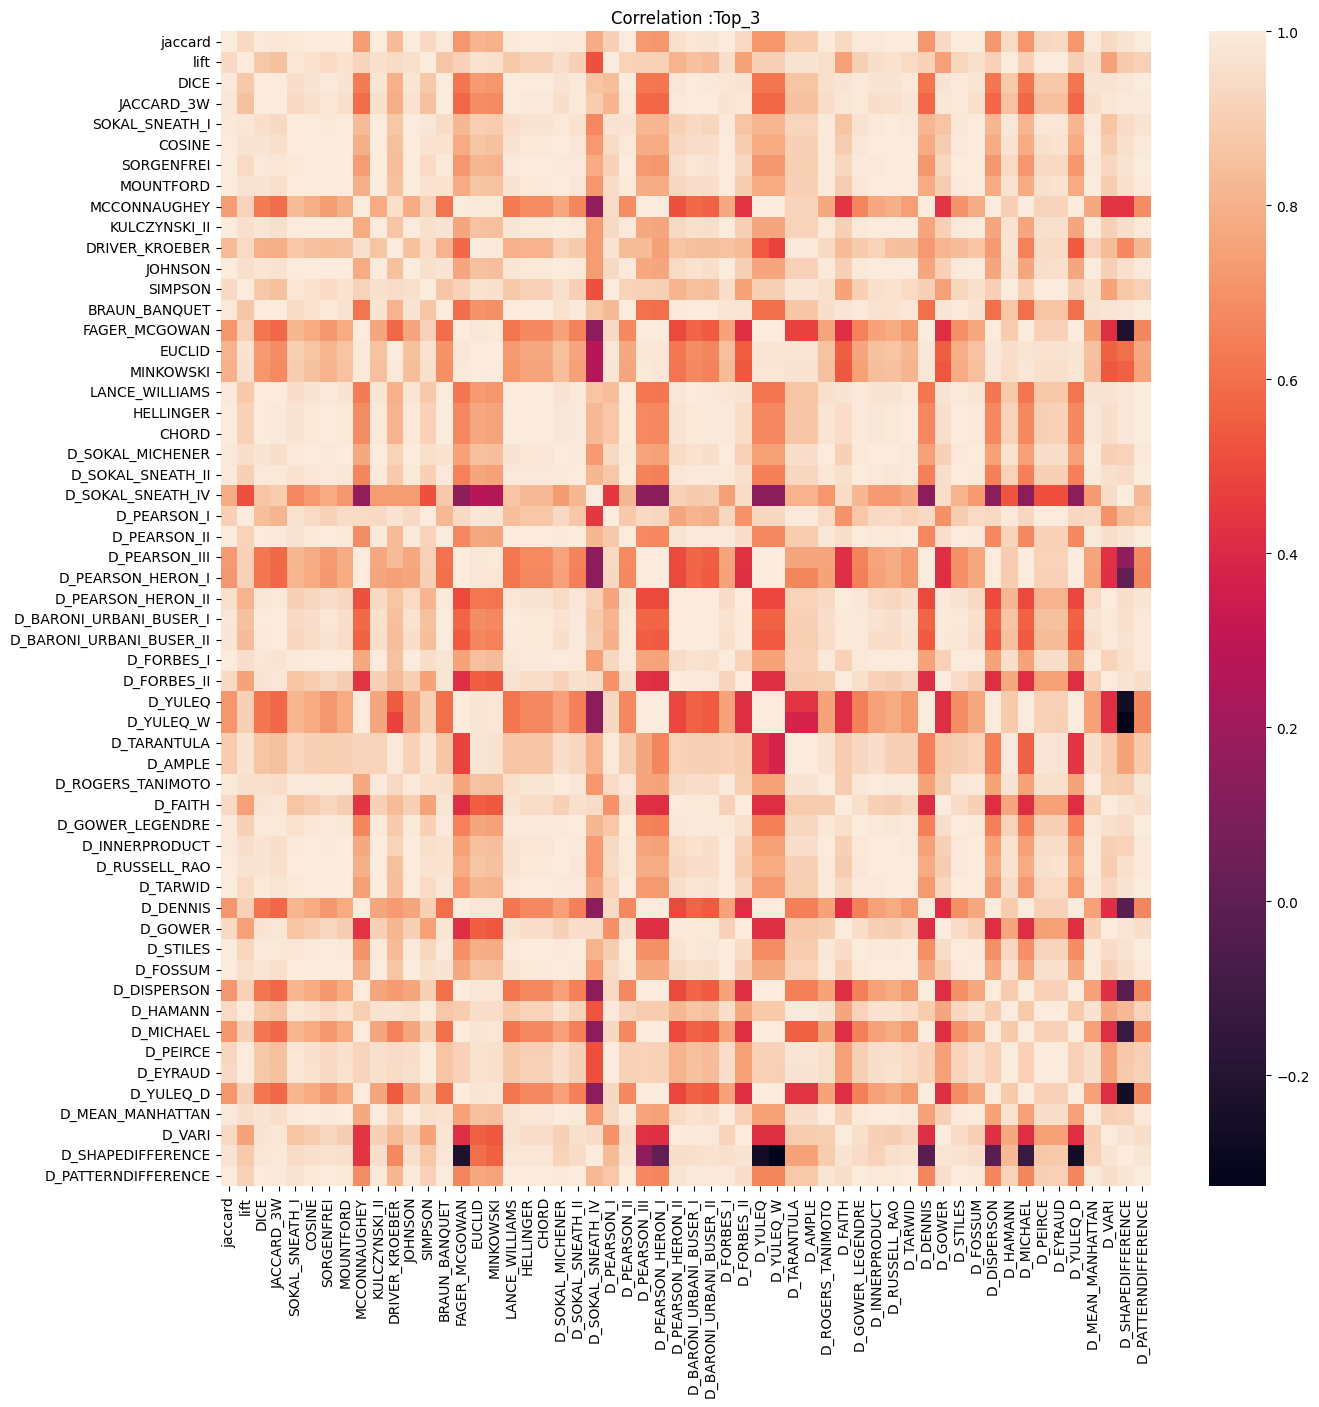

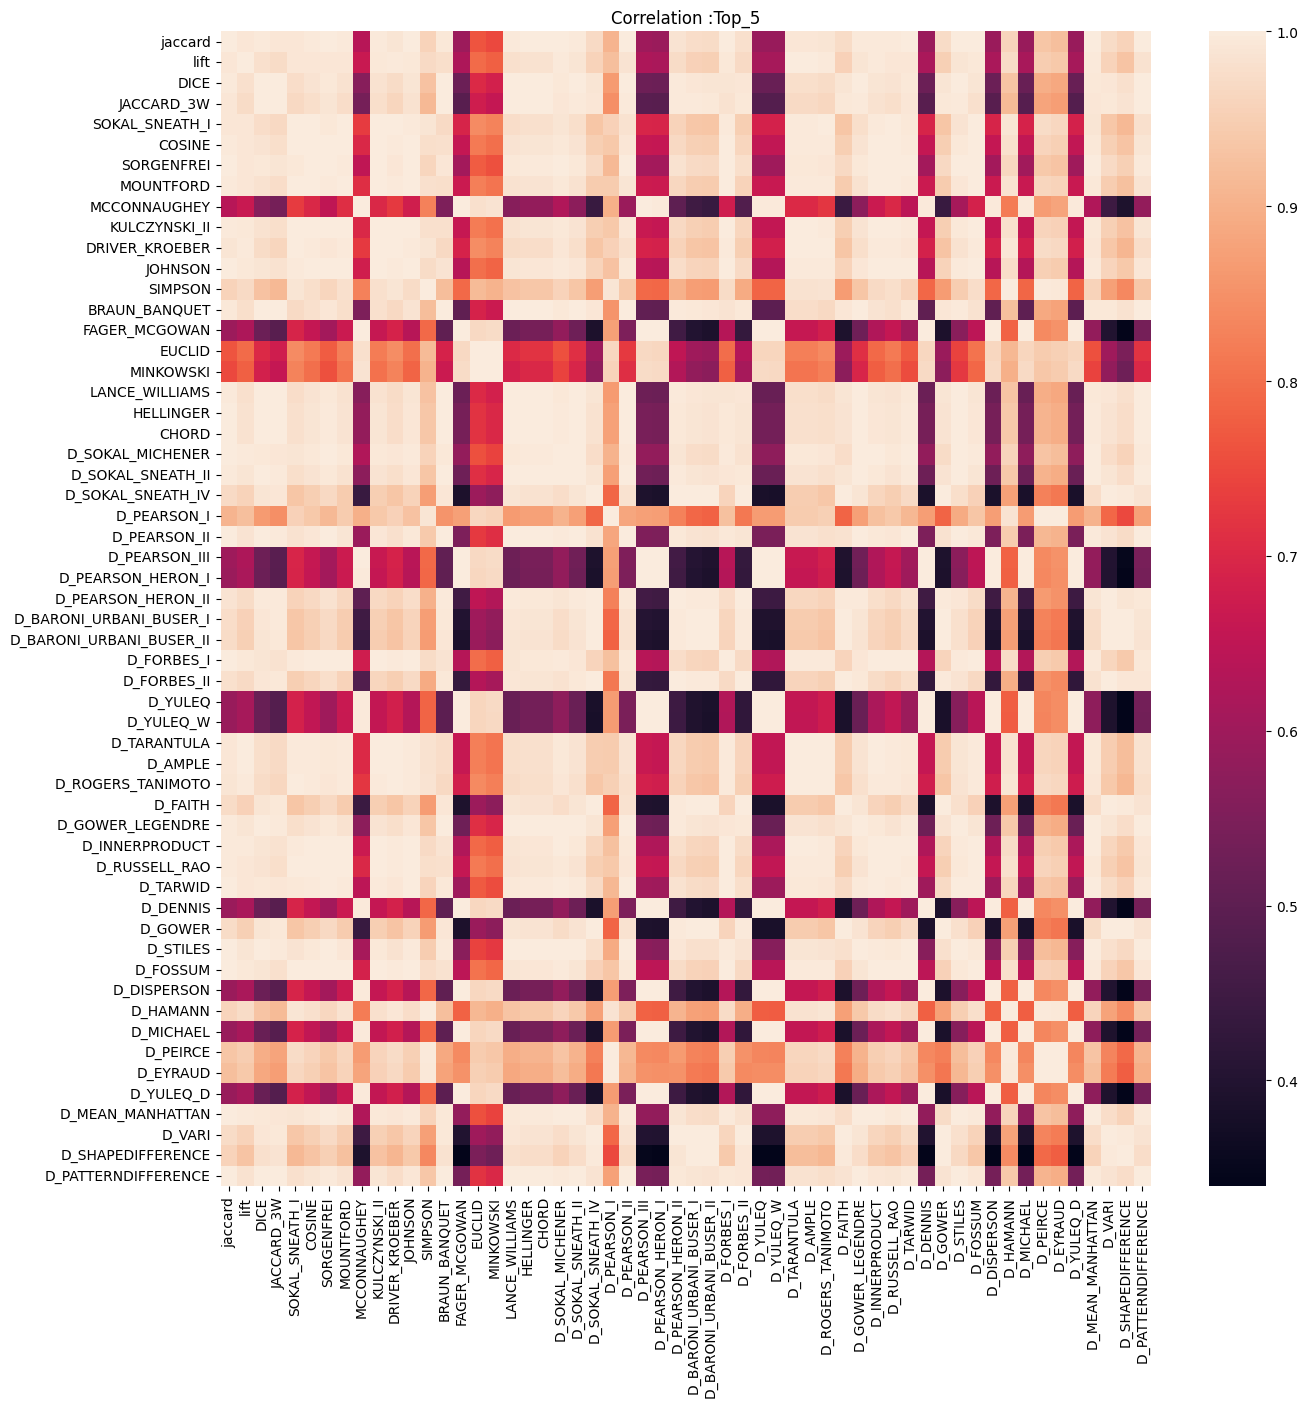

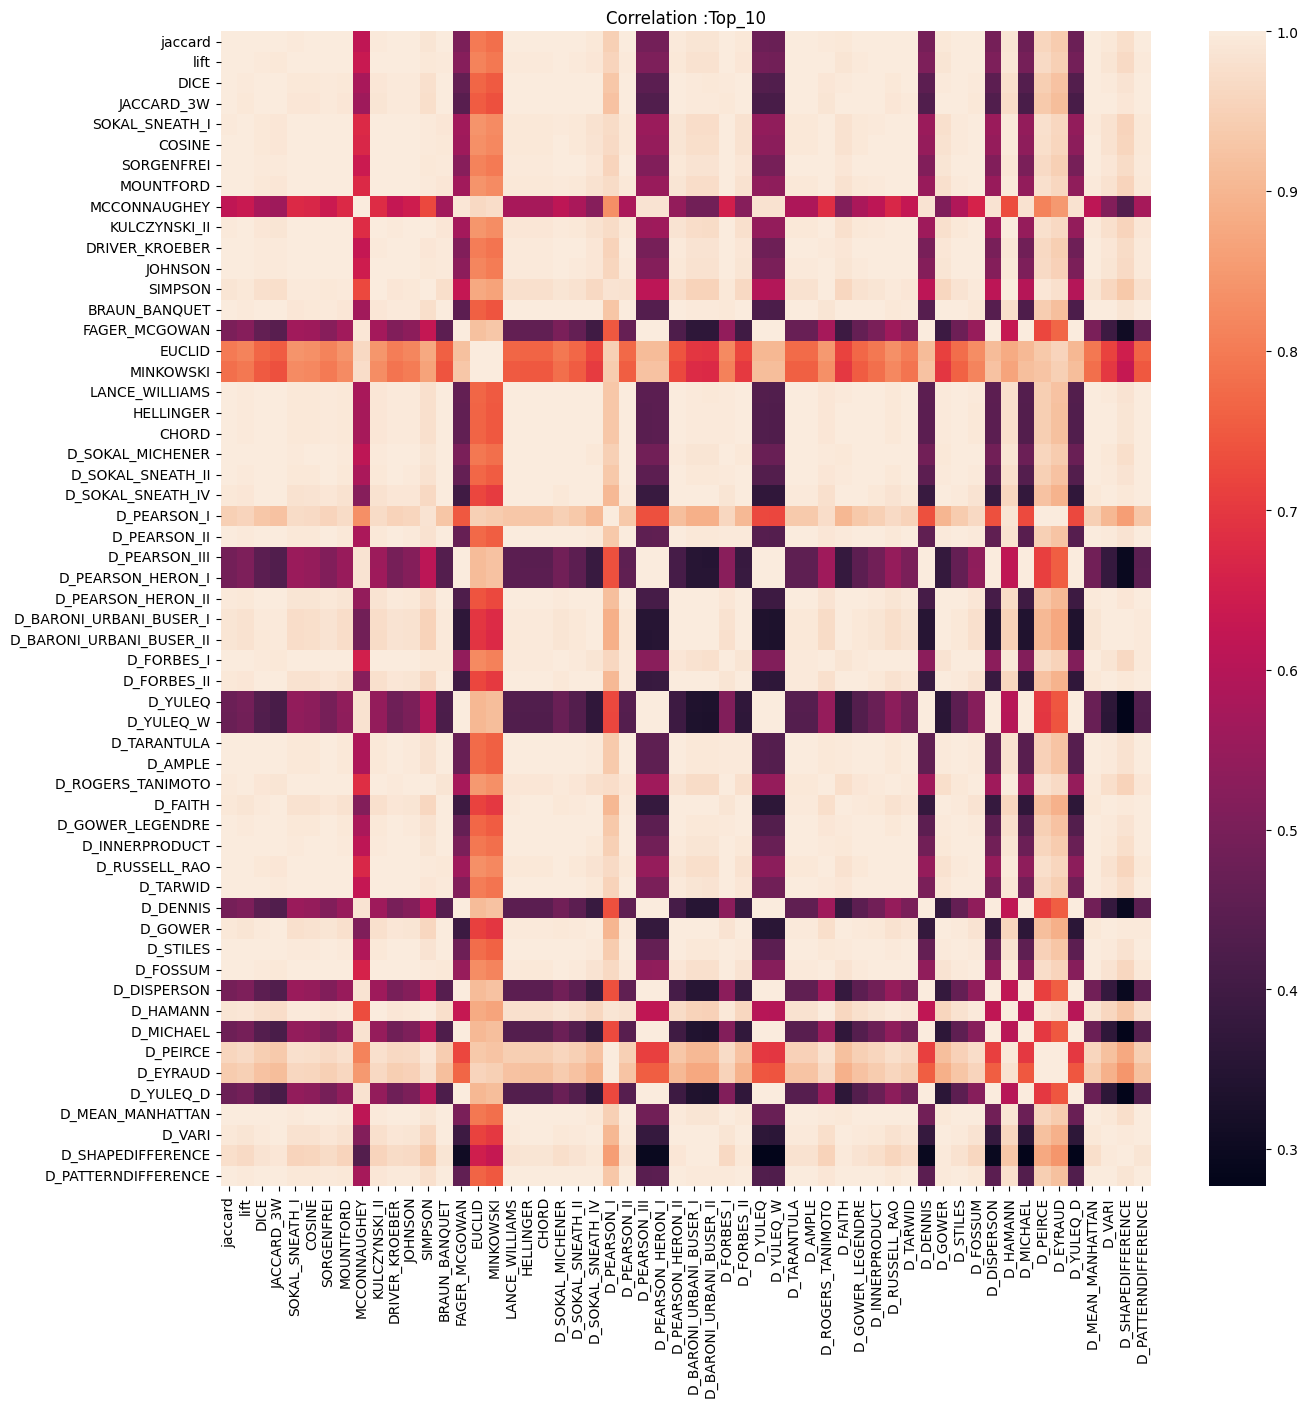

In [204]:
for i in range(len(list_top_k)):
    plt.figure(figsize=(15,15))
    sns.heatmap(data=list_dataframe[i].T.corr())
    plt.title(f"Correlation :Top_{list_top_k[i]}")
    plt.savefig(f'correlation ML_1M Top_{list_top_k[i]}.png',dpi=1000)

	The end